# Simulacion - 75.26
## TP1 - Xorshift RNGs
### Grupo 4 
### Integrantes: Joaquín Rivero, Juan Pablo Aschieri, Diego Civini, Francisco Rovira Rossel

In [3]:
import matplotlib.pyplot as plt
import numpy as np

## Ejercicio 1

Hacemos una clase `xorshift_generator` que dada una semilla devuelve un generador de numeros aleatorios de 32 bits realizando operaciones logicas de shifteo y xor. Los valores usados para la cantidad de shifteos fueron sacados del paper.

In [4]:
class xorshift_generator:
    def __init__(self, seed):
        self.x = seed
        self.y = 463820370
        self.z = 138409373
        self.w = 12872349


    def rand(self):
        tmp = ( self.x^ (self.x <<13) ) 
        self.x = self.y
        self.y = self.z
        self.z = self.w
        self.w = (self.w^(self.w>>17) ) ^ (tmp^(tmp>>5))
        return self.w & 0xffffffff
    
    def normalized_rand(self):
        return self.rand() / (2**32 -1)

Obtenemos un generador con una semilla y obtenemos 100000 numeros para analizar los resultados.

In [181]:
generator = xorshift_generator(123456789)

In [51]:
rand_numbers = []
for i in range(100000):
    rand_numbers.append(generator.rand())
print(rand_numbers[:5])

[634047618, 827895943, 4188086042, 2971408131, 1743656811]


Graficamos los numeros en un histograma para obtener una representacion visual aproximada de su distribucion. Como buscamos numeros aleatorios entre 0 y 2^32 -1 deberia ser un grafico similar a una dist uniforme ente 0 y 2^32 -1

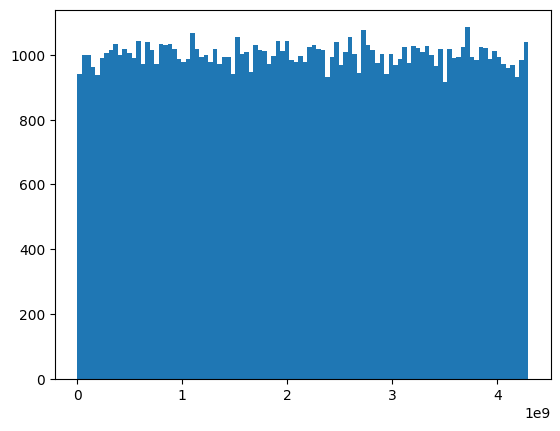

In [52]:
plt.hist(rand_numbers, bins = 100)
plt.show()

Si bien no es perfecto se puede ver como aproximadamente los distintos box tienen la misma cantidad de ocurrencias, haciendo que el grafico dado se paresca a una meseta, que es el grafico que deberia tener una uniforme.

Si queremos obtener numero aleatorios entre 0 y 1 utilizando el xorshift generator, basta con generar un numero aleatorio de la misma manera y luego normalizarlo. Para ello dividimos al numero por el mayor valor posible, 2^32 -1. De esta manera optenemos un numero aleatorio entre 0 y 1 con el metodo normalized_rand

In [21]:
rand_numbers_normalized = []
for i in range(100000):
    rand_numbers_normalized.append(generator.normalized_rand())
print(rand_numbers_normalized[:5])

[0.14762571504051464, 0.19275954533199768, 0.9751147690636839, 0.6918348678601521, 0.40597673771110754]


De la misma forma graficamos un histograma para ver si la distribucion de los numeros se asemeja a una distribucion uniforme entre 0 y 1.

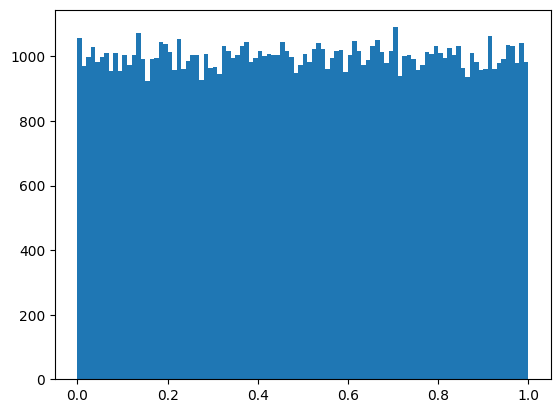

In [54]:
plt.hist(rand_numbers_normalized, bins = 100)
plt.show()

De una forma similar, podemos ver a esta distribucion uniforme "de a pares", es decir, podemos graficar en el plano XY pares de números aleatorios generados.

In [24]:
pairs_of_rand_numbers_normalized = []
for i in range(50000):
    pairs_of_rand_numbers_normalized.append((generator.normalized_rand(), generator.normalized_rand()))

Ya obtenido el arreglo con las tuplas de numeros aleatorios, procedemos a graficarlos en un plano cartesiano. Si los números siguen una distribuicion uniforme entre 0 y 1, deberíamos ver que el gráfico se asemeja a un cuadrado de lado 1 cuyos vertices son (0,0), (0,1), (1,0), (1,1).

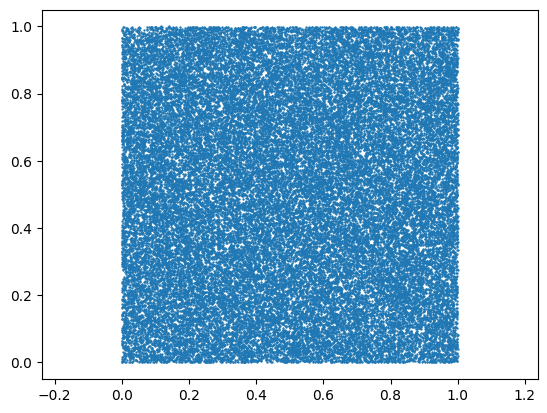

In [25]:
x = [p[0] for p in pairs_of_rand_numbers_normalized]
y = [p[1] for p in pairs_of_rand_numbers_normalized]
plt.scatter(x, y, s=0.5)
plt.axis('equal')
plt.show()

Visualmente se puede ver que, efectivamente, los puntos en conjunto forman un cuadrado y estan distribuidos uniformente sobre el grafico, lo cual tiene sentido ya que las coordenadas X e Y son independientes, entonces al tener una muestra de un tamaño considerable de tuplas de números aleatorios entre 0 y 1 (en este caso 50 mil tuplas), estos tienden a rellenar un cuadrado de lado 1. 

## Ejercicio 2

enunciado

### Test chi2


Si bien el test de la chi2 necesita que la distribución sea discreta, nosotros tenemos una distribución continua y uniforme. Esto presenta un problema. Para poder realizar este test, podemos discretizar la distribucion juntando valores de intervalos en bins. En este caso vamos a usar 100 bins.

Este test nos permite saber con un nivel de significación alfa (usaremos 0.05) si los valores que generamos NO tienen distribución uniforme. Para ello tomamos como hipótesis nula que la distribucion **es** uniforme en el intervalo correspondiente.  
Si podemos rechazar la hipotesis nula: afirmaremos que la distribución no es uniforme.  
En caso de no rechazar la hipótesis nula: no podemos afirmar que la distribución es uniforme.

Asumo h0 como que la dist es uniforme. Este test NO SIRVE para decir si una dist es uniforme. Sirve para decir, si se rechaza h0 puedo decir con un nivel de significacion alfa que la dist no es uniforme. Si no se rechaza H0 entonce NO ES QUE ES UNIFORME, si no que PUEDE ser uniforme.

In [57]:
from scipy.stats import chi2

In [58]:
def get_frequency(rand_numbers, bins, max):
    frequency = [0 for i in range(bins)]
    bin_size = max/bins

    for i in rand_numbers:
        j = 0
        seguir = True
        while seguir:
            if i < bin_size:
                frequency[j] += 1
                seguir = False
            else:
                j += 1
                i -= bin_size

    return frequency

In [59]:
def test_chi2_for_uniform_distribution(rand_numbers, bins, max, significance_level):
    frequency = get_frequency(rand_numbers, bins, max)

    expected_frecuency = len(rand_numbers)/bins
    aux = 0
    for i in frequency:
        aux += (i - expected_frecuency)**2
    d2 = aux/expected_frecuency

    upper_limit = chi2.ppf(1 - significance_level, df=bins-1)

    print(f"D2: {d2}")
    print(f"Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: {upper_limit}")
    if d2 > upper_limit:
        print("Hay suf evidencia para rechazar h0, es decir que podemos afirmar que la distribucion no es uniforme con un nivel de significacion de 0.05")
    else:
        print("No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme")

In [60]:
int((2**32-1)/100)


42949672

Creamos un xorshift generator y le aplicamos el test de la chi2 para tanto el generador de numeros entre 0 y 2^32-1 y el de numeros entre 0 y 1, probando generar 1000, 10000 y 100000 numeros.

In [61]:
generator = xorshift_generator(565555555)

#### Pruebas para generador

Probamos el generador con una muestra de 100 numeros

In [62]:
rand_numbers =[]
for i in range(100):
    rand_numbers.append(generator.rand())

test_chi2_for_uniform_distribution(rand_numbers, 100, 2**32 - 1, 0.05)

D2: 64.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


Esto se debe a que no hay grandes diferencias entre los distintos bins. Como se muestra en el siguiente grafico.

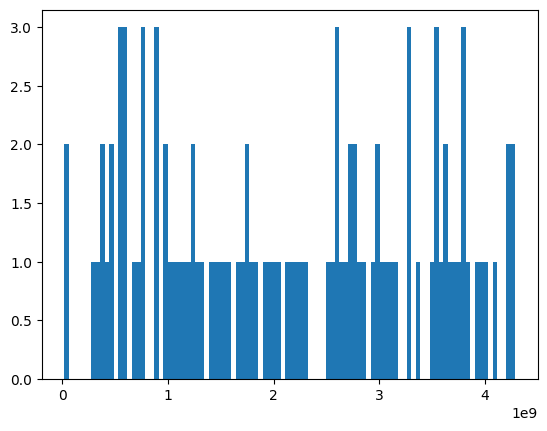

In [63]:
plt.hist(rand_numbers, bins = 100)
plt.show()

Sin embargo esto depende enteramente de la suerte que tengamos al generar la muestra, ya que a pesar de que sea poco probable, se podria dar el caso de que los 100 numeros estan en el mismo bin. Por ejemplo en el siguiente caso

In [64]:
#dejamos pasar 100 numeros de la semilla
for i in range(300):
    generator.rand()

rand_numbers =[]
for i in range(100):
    rand_numbers.append(generator.rand())

test_chi2_for_uniform_distribution(rand_numbers, 100, 2**32 - 1, 0.05)

D2: 132.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
Hay suf evidencia para rechazar h0, es decir que podemos afirmar que la distribucion no es uniforme con un nivel de significacion de 0.05


En este caso vemos que se rechaza h0, es decir que podemos asegurar bajo un nivel de significancia 0.05 que la distribucion no es de tipo uniforme. Sin embargo esto se debe a que tuvimos "mala suerte" a la hora de obtener los numeros. Lo que se ve en el sigueinte grafico que contiene muchas mas irregularidades que el anterior

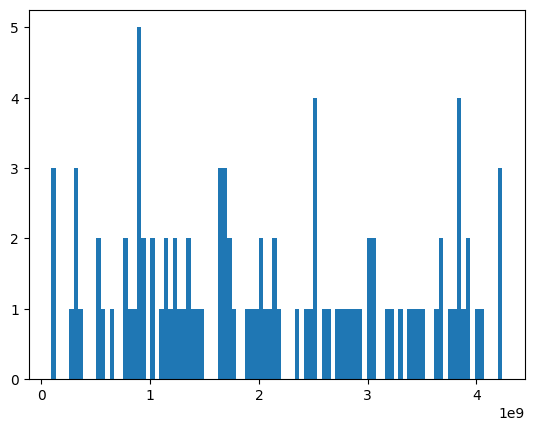

In [65]:
plt.hist(rand_numbers, bins = 100)
plt.show()

Para evitar que nuestros resultados esten muy influenciados por la "suerte" que tengamos al obtener numeros, los generamos en magnitudes mas grandes, esto hara que sea mucho menos probable que el test de que se rechaza la hipotesis nula por "mala suerte."

Probamos el generador con una muestra de 10000 numeros

In [66]:
rand_numbers =[]
for i in range(10000):
    rand_numbers.append(generator.rand())

test_chi2_for_uniform_distribution(rand_numbers, 100, 2**32 - 1, 0.05)

D2: 92.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


Probamos el generador con una muestra de 100000 numeros

In [67]:
rand_numbers = []
for i in range(100000):
    rand_numbers.append(generator.rand())
test_chi2_for_uniform_distribution(rand_numbers, 100, 2**32 - 1, 0.05)

D2: 111.282
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


#### Pruebas para generador normalizado

A partir de aquí, se prueba el generador para numeros randoms entre 0 y 1, para 100, 10000 y 100000 numeros. Es muy similar a lo obtenido en el caso anterior ya que para generat numeros entre 0 y 1 se utiliza el generador testeado anteriormente.

In [68]:
rand_numbers = []
for i in range(100):
    rand_numbers.append(generator.normalized_rand())
test_chi2_for_uniform_distribution(rand_numbers, 100, 1, 0.05)

D2: 100.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


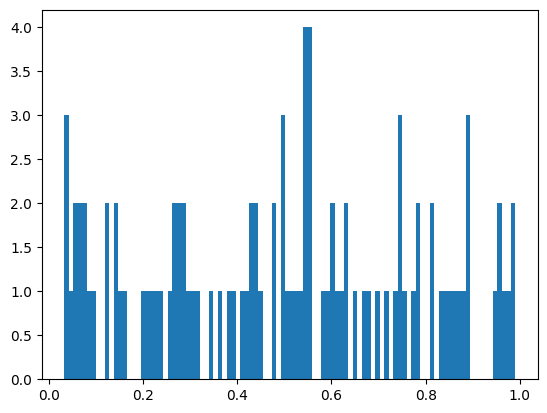

In [69]:
plt.hist(rand_numbers, bins = 100)
plt.show()

De la misma manera que en el generador anterior, al ser muy pocos los numeros que generamos nuestro test tiene altas chances de dar resultados diferentes segun que tanta "suerte" tengamos al generar los 100 numeros

In [70]:
rand_numbers = []
for i in range(100):
    rand_numbers.append(generator.normalized_rand())
test_chi2_for_uniform_distribution(rand_numbers, 100, 1, 0.05)

D2: 130.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
Hay suf evidencia para rechazar h0, es decir que podemos afirmar que la distribucion no es uniforme con un nivel de significacion de 0.05


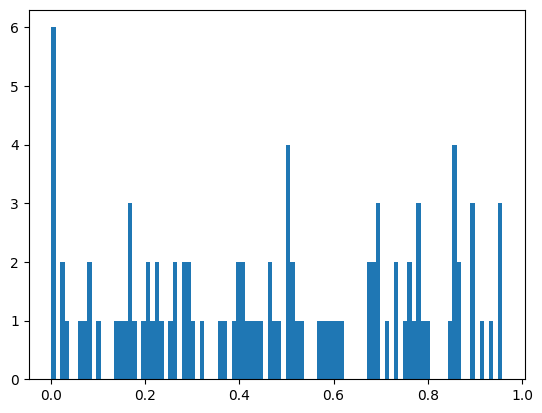

In [71]:
plt.hist(rand_numbers, bins = 100)
plt.show()

Probamos el generador con una muestra de 10000 numeros

In [72]:
rand_numbers = []
for i in range(10000):
    rand_numbers.append(generator.normalized_rand())
test_chi2_for_uniform_distribution(rand_numbers, 100, 1, 0.05)

D2: 92.48
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


Probamos el generador con una muestra de 100000 numeros

In [73]:
rand_numbers = []
for i in range(100000):
    rand_numbers.append(generator.normalized_rand())
test_chi2_for_uniform_distribution(rand_numbers, 100, 1, 0.05)

D2: 80.902
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


### Test TCL

**H0** : la distribucion **no** es $uniforme (0,m)$, que es equivalente a que la media $μ != (m-0)/2$  
**H1** : la distribucion es $uniforme (0,m)$  

Para el caso del generador base tendremos una distribucion uniforme discreta entre 0 y 2 **32 -1 y para el generador normalizado uns distribucion discreta continua entre 0 y 1.

Por el Teorema Central del Limite, podemos decir que la sumatoria de variables aleatorias de igual media y varianza tiende a una normal. Luego, podemos plantear un test de nivel de significacion asintotico alfa.

$(\sum_{i=1}^{n} t_i - nμ)/ \sqrt{nVAR[X]}$  aproximadamente una normal estandar Z

Entonces podemos plantear un test donde rechazamos h0 en la zona central que acumule probabilidad alfa

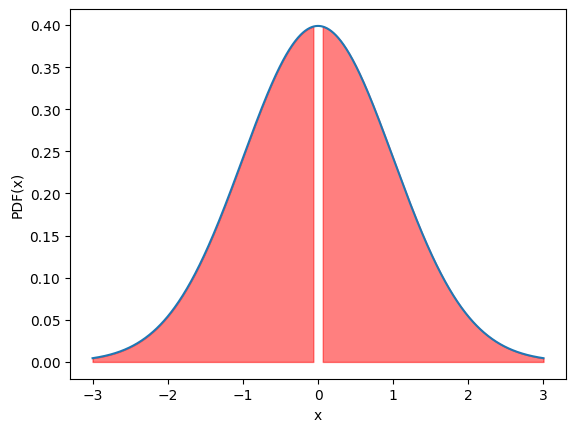

In [74]:
from scipy.stats import norm

# Crear un array de valores x en el rango de -3 a 3
x = np.linspace(-3, 3, 1000)
alpha = 0.05
# Calcular la función de densidad de probabilidad (PDF) de la distribución normal estándar
pdf = np.exp(-0.5*x**2) / np.sqrt(2*np.pi)
# Trama la PDF en un gráfico
plt.plot(x, pdf)

# Marca los cuantiles del 5% y del 95% con un relleno rojo
lower_quantile = norm.ppf((1-alpha)/2)  # cuantil del 5%
upper_quantile = -norm.ppf((1-alpha)/2)  # cuantil del 95%

plt.fill_between(x, pdf, where=(x < lower_quantile), color='red', alpha=0.5)
plt.fill_between(x, pdf, where=(x > upper_quantile), color='red', alpha=0.5)

# Agrega etiquetas al gráfico y muestra el resultado
plt

plt.xlabel('x')
plt.ylabel('PDF(x)')
plt.show()

Es decir que rechazaremos h0 cuando $|z| < q(1-alpha)/2$ que es aproximadamente $$|(\sum_{i=1}^{n} t_i - nμ)/ \sqrt{nVAR[X]}| < q(1-alpha)/2$$

siedo :
+$μ = m/2$ y 
+ var[x] = m^2/12$n

Este test funcionara mejor cuantos mas numeros aleatorios se generen

Creamos un xorshift generator para aplicarte el test

In [97]:
generator = xorshift_generator(565555555)

In [98]:
def tcl_test_for_uniform_distribution(rand_numbers, max, varianza ,significance_level):
    n = len(rand_numbers)
    numerator = sum(rand_numbers) - n *(max/2)
    denominator = (n*varianza(rand_numbers,max))**1/2
    value = numerator/denominator


    print(n)
    print(numerator)
    print(denominator)
    print(value)
    print(norm.ppf((1-significance_level)/2))
    if (value > norm.ppf((1-significance_level)/2)) and (value < -norm.ppf((1-significance_level)/2)):
        print("Hay suf evidencia para rechazar h0")
    else:
        print("No hay suf evidencia para rechazar h0")
    

In [101]:
def discrete_uniform_var(rand_numbers ,max):
    return (((max+1)**2)-1)/12

In [102]:
def continue_uniform_var(rand_numbers, max):
    return ((max)**2)/12

In [103]:
rand_numbers = []
for i in range(1):
    rand_numbers.append(generator.rand())
tcl_test_for_uniform_distribution(rand_numbers, 2**32-1, discrete_uniform_var, 0.05 )
print(rand_numbers)
print

1
-1545505512.5
7.686143364045646e+17
-2.0107685210889875e-09
-0.06270677794321385
Hay suf evidencia para rechazar h0
[601978135]


<function print>

In [119]:
rand_numbers = []
for i in range(10000):
    rand_numbers.append(generator.normalized_rand())
tcl_test_for_uniform_distribution(rand_numbers, 1, continue_uniform_var, 0.05 )
print(rand_numbers)
print

10000
-40.49967072963045
416.66666666666663
-0.0971992097511131
-0.06270677794321385
No hay suf evidencia para rechazar h0
[0.6025709015323247, 0.863369290917965, 0.5388758919525137, 0.961460858108816, 0.6677014209953372, 0.8174486602231508, 0.711111011614816, 0.8397602480463126, 0.4590198577984748, 0.3846363249199084, 0.07392838529169754, 0.7197582206501993, 0.5193159478994356, 0.12091345645508576, 0.7710859127741041, 0.5436459706499348, 0.9929674111755955, 0.018766459314796716, 0.6428970344464521, 0.7632116556081948, 0.20580382021279164, 0.40192100508183265, 0.4403448506352363, 0.429258140602442, 0.8620851130369318, 0.5766620427781395, 0.5879722460145066, 0.40878650229628816, 0.8052898586739995, 0.988150100919453, 0.6253636629845397, 0.4641684224978481, 0.6695615431921467, 0.46780428417674363, 0.8276074861240591, 0.859146024300518, 0.7046098792237718, 0.4046971039857476, 0.6394826373177307, 0.8897613326296586, 0.027504820615869206, 0.9884050330120151, 0.559724597390677, 0.69584029859

<function print>

### Test Kolmogorov - Smirnov
https://www.statology.org/kolmogorov-smirnov-test-python/ (de donde saque, lo pego aca para no perder el link)

In [5]:
from scipy.stats import kstest, uniform

**H0** : La distribucion es uniforme discreta  
**H1** : La distribucion **no** es uniforme discreta

Nuestra hipotesis nula es que el arreglo 'data' (generado por nuestro RNG) sigue una distribucion uniforme.
Si el p-value es menor que el nivel de significacion (por default = 0.05) entonces se rechaza la hipotesis nula y decimos que hay suficiente evidencia para decir que
la muestra de numeros en el arreglo 'data' no viene de una distribucion uniforme.
Empezamos testeando para 100 elementos.

In [6]:
import random
generator = xorshift_generator(695619357)

In [40]:
def test_kolmogorov_smirnov(distribution, max, quantity, func):
    data = []
    for i in range(quantity):
        data.append(func())
    p_value = kstest(data, distribution, args=(0, max)).pvalue

    if p_value > 0.05:
        print('No hay evidencia para rechazar la hipotesis nula.')
    else:
        print('Rechazamos la hipotesis nula. Data no sigue una distribucion uniforme.')
    print(f'El p-valor es: {p_value}')
    plt.hist(data, bins=100)
    plt.show()


In [ ]:
test_kolmogorov_smirnov(uniform.cdf, (2**32)-1, 100, generator.rand)

In [ ]:
test_kolmogorov_smirnov(uniform.cdf, (2**32) - 1, 100, generator.rand)

Seguimos con 10000 elementos.

In [ ]:
test_kolmogorov_smirnov('randint', (2**32) - 1, 10000, generator.rand)

Finalizamos el testeo con Kolgomorov - Smirnov del RNG con 100000 elementos.

In [ ]:
test_kolmogorov_smirnov('randint', (2**32) - 1, 100000, generator.rand)

Ahora testemos con las mismas cantidades de elementos pero para el RNG normalizado. Empezamos con 100 elementos.

In [ ]:
test_kolmogorov_smirnov('uniform', 1, 100, generator.normalized_rand)

Seguimos con 10000

In [ ]:
test_kolmogorov_smirnov(uniform.cdf, 1, 10000, generator.normalized_rand)

Finalizamos con 100000

In [ ]:
test_kolmogorov_smirnov('uniform', 1, 100000, generator.normalized_rand)

In [ ]:
def test_random_python(distribution, max, quantity):
    print("hola soy python")
    data = []
    for _ in range(quantity):
        data.append(random.randint(0, max))
    p_value = kstest(data, distribution, args=(0, max)).pvalue

    if p_value > 0.05:
        print('No hay evidencia para rechazar la hipotesis nula.')
    else:
        print('Rechazamos la hipotesis nula. Data no sigue una distriibucion uniforme.')
    plt.hist(data, bins=100)
    plt.show()
    print(f'El p-value es: {p_value}')

Despues del análisis de los resultados de los test de _Komolgorov Smirnov_ con las distintas muestras, los resultados tendieron a ser los siguientes:  
  
En la mayoria de las corridas, el test arroja que no tenemos evidencia suficiente para rechazar **H0**, es decir, no hay evidencia para afirmar que la distribucion **no** es uniforme. Esto lo podemos ver también con el resultado del p-valor: el significado que tiene es la probabilidad de cometer un error de tipo 1 (rechazar **H0** cuando es verdadera), cuando el p-valor toma valores muy altos nos indica que hay una probabilidad muy alta de que **H0** sea verdadera si elegimos rechazarla.  
  
Sin embargo, el resultado del test es fluctuante (por ejemplo, en corridas consecutivas los p-valores iban desde cerca de 0.9 a casi 0.01, lo cual nos confundía bastante). Primero creimos que el error estaba en nuestro generador, así que probamos con el generador de numeros aleatorios de python _randint_. Como vimos que también fluctuaba, pensamos que era un error al testear.   
  
Luego de pensarlo y debatirlo, llegamos a una conclusion razonable: El p-valor varía porque la muestra varía (generamos nuevos numeros aleatorios en cada corrida del test), y como el test de hipótesis depende casi exclusivamente de la muestra, eso explica las eventuales variaciones que haya. Que a veces el p-valor sea lo suficientemente chico como para rechazar **H0** nos dice que en esa corrida se genero una muestra que podia contener sesgos y acumulaciones de ciertos numeros en cierto intervalo, lo que hacia que se incline la balanza a favor de decidir que el generador no fuese "uniforme". Este caso puede ocurrir con una probabilidad baja, pero esta no es nula, asi que puede pasar.  